# Fake News Detection Using RNN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png">

This notebook aims to classify fake news from real news using a recurrent neural network. To simplify the text preprocessing procedure, we will be using the built in functions from tensorflow instead of more established libraries like NLTK.

**Here are the results: **

* Accuracy on testing set: 0.9904231625835189
* Precision on testing set: 0.9879573876794813
* Recall on testing set: 0.9920930232558139

*Free free to provide me with feedbacks.  

**New update: confusion matrix is now expressed in terms of percentage rather than frequency.**


Image Source: https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png
Code is on my Github: https://github.com/therealcyberlord


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
plt.style.use('ggplot')
from sklearn.utils import resample

from google.colab import drive
import zipfile

In [2]:
import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Dropout, Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Read the data

In [44]:
real_url = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv"
fake_url = "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv"

# Read the csv file from the url
fake = pd.read_csv(fake_url)
real = pd.read_csv(real_url)

# A way to delete rows with empty or null values
fake = fake[~fake.isna().any(axis=1)]
real = real[~real.isna().any(axis=1)]

In [45]:
fake["label"] = 1
real["label"] = 0

<ipython-input-45-89cb7829fca8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake["label"] = 1


In [46]:
df = pd.concat([fake, real], axis =0 )
df.head(10)

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,1
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,1
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,1
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,1
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,1
5,gossipcop-5189580095,www.townandcountrymag.com/society/tradition/a1...,Here's What Really Happened When JFK Jr. Met P...,890253005299351552\t890401381814870016\t890491...,1
6,gossipcop-9588339534,www.foxnews.com/entertainment/2016/12/16/bigge...,Biggest celebrity scandals of 2016,683226380742557696\t748604615503929345\t748604...,1
7,gossipcop-8753274298,www.eonline.com/news/958257/caitlyn-jenner-add...,Caitlyn Jenner Addresses Rumored Romance With ...,1026891446081728512\t1026891745219543043\t1026...,1
8,gossipcop-8105333868,www.inquisitr.com/3871816/taylor-swift-reporte...,Taylor Swift Reportedly Reacts To Tom Hiddlest...,818928533569437697\t819100640878202880\t819174...,1
9,gossipcop-2803748870,www.huffingtonpost.com/entry/kate-mckinnon-the...,"For The Love Of God, Why Can't Anyone Write Ka...",816030248190046212\t816030859484626947\t816049...,1


Checking for null values

## EDA

In [47]:
df.head()

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,1
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,1
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,1
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,1
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20645 entries, 0 to 16815
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20645 non-null  object
 1   news_url   20645 non-null  object
 2   title      20645 non-null  object
 3   tweet_ids  20645 non-null  object
 4   label      20645 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 967.7+ KB


Check out the distribution of fake news compare to real news

([<matplotlib.patches.Wedge at 0x7fd95b1a0f40>,
 [Text(-0.8138650525648107, 0.8818297319855336, 'Fake'),
  Text(0.8138650938462391, -0.8818296938857598, 'True')],
 [Text(-0.4747546139961395, 0.5144006769915612, '23.7%'),
  Text(0.4747546380769727, -0.5144006547666932, '76.3%')])

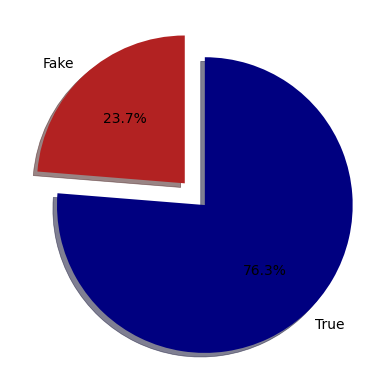

In [49]:
# Checking if our df is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [55]:
# Get the majority class
majority_class = df[df["label"] == 0]

# resample the majority class (0 which is real)
majority_resampled = resample(majority_class,
                             replace=True,
                             n_samples=df["label"].value_counts()[1],
                             random_state=123)

# Combine the resampled majority class with the majority class
df_resampled = pd.concat([df[df["label"] == 1], majority_resampled])

([<matplotlib.patches.Wedge at 0x7fd7e57f1420>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

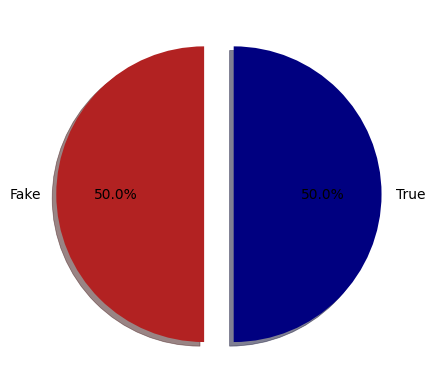

In [56]:
# Checking if our df_resampled is well balanced
label_size = [df_resampled['label'].sum(),len(df_resampled['label'])-df_resampled['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

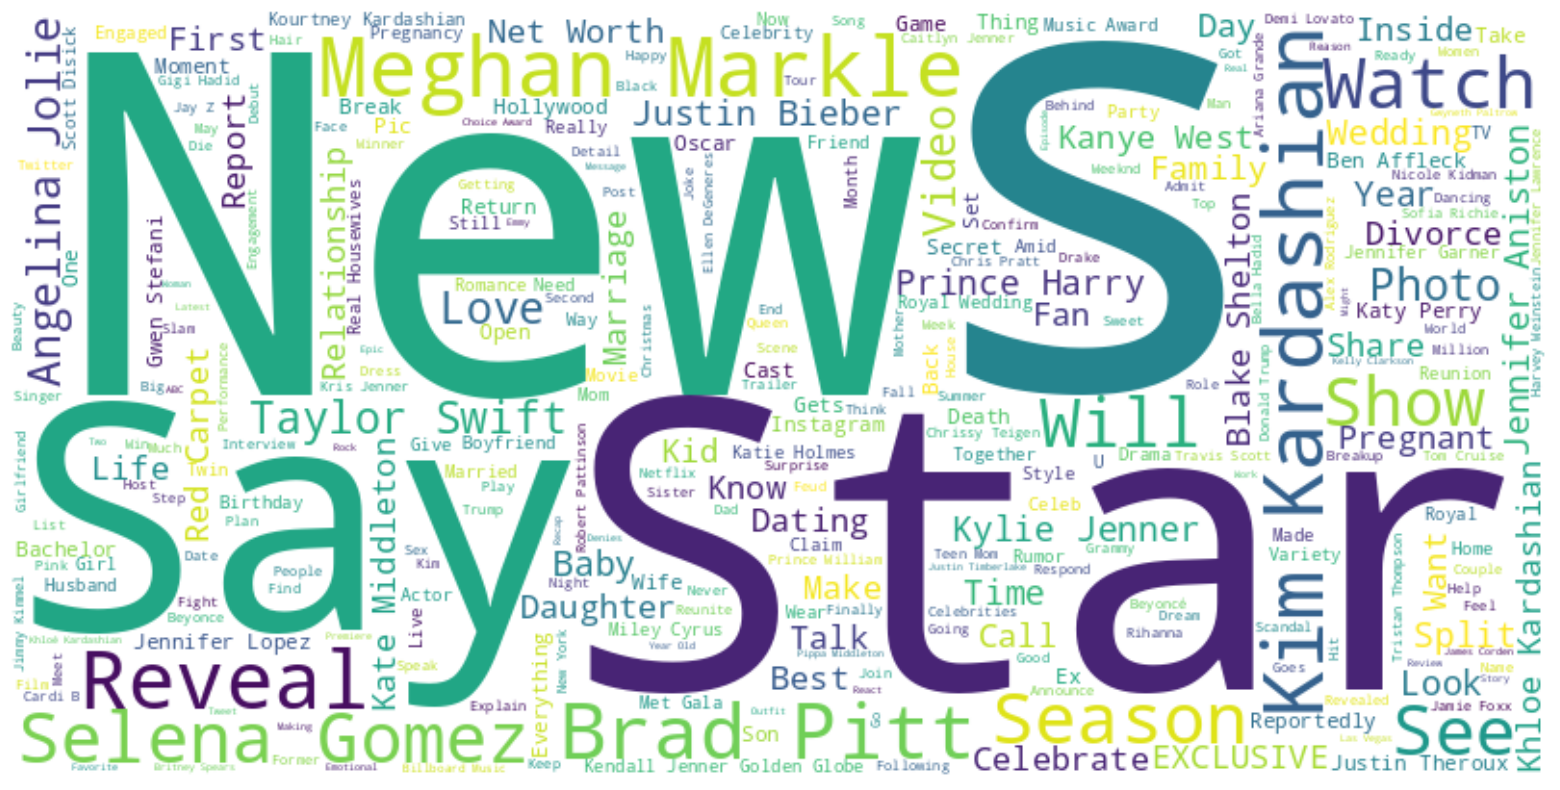

In [50]:
titles = ' '.join(title for title in df['title'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Split into training and testing

In [59]:
features = df_resampled['title']
targets = df_resampled['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

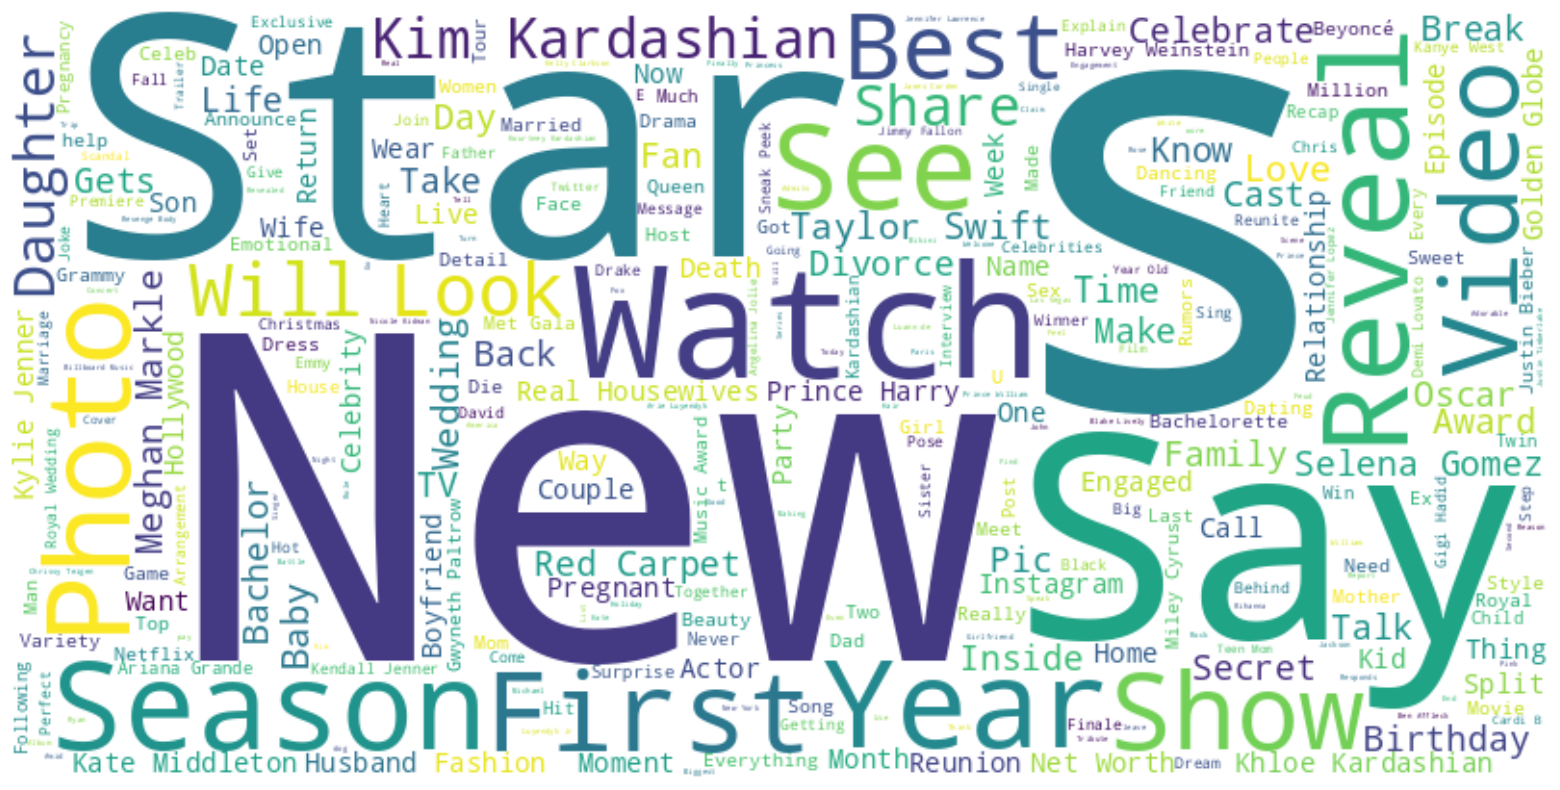

In [60]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

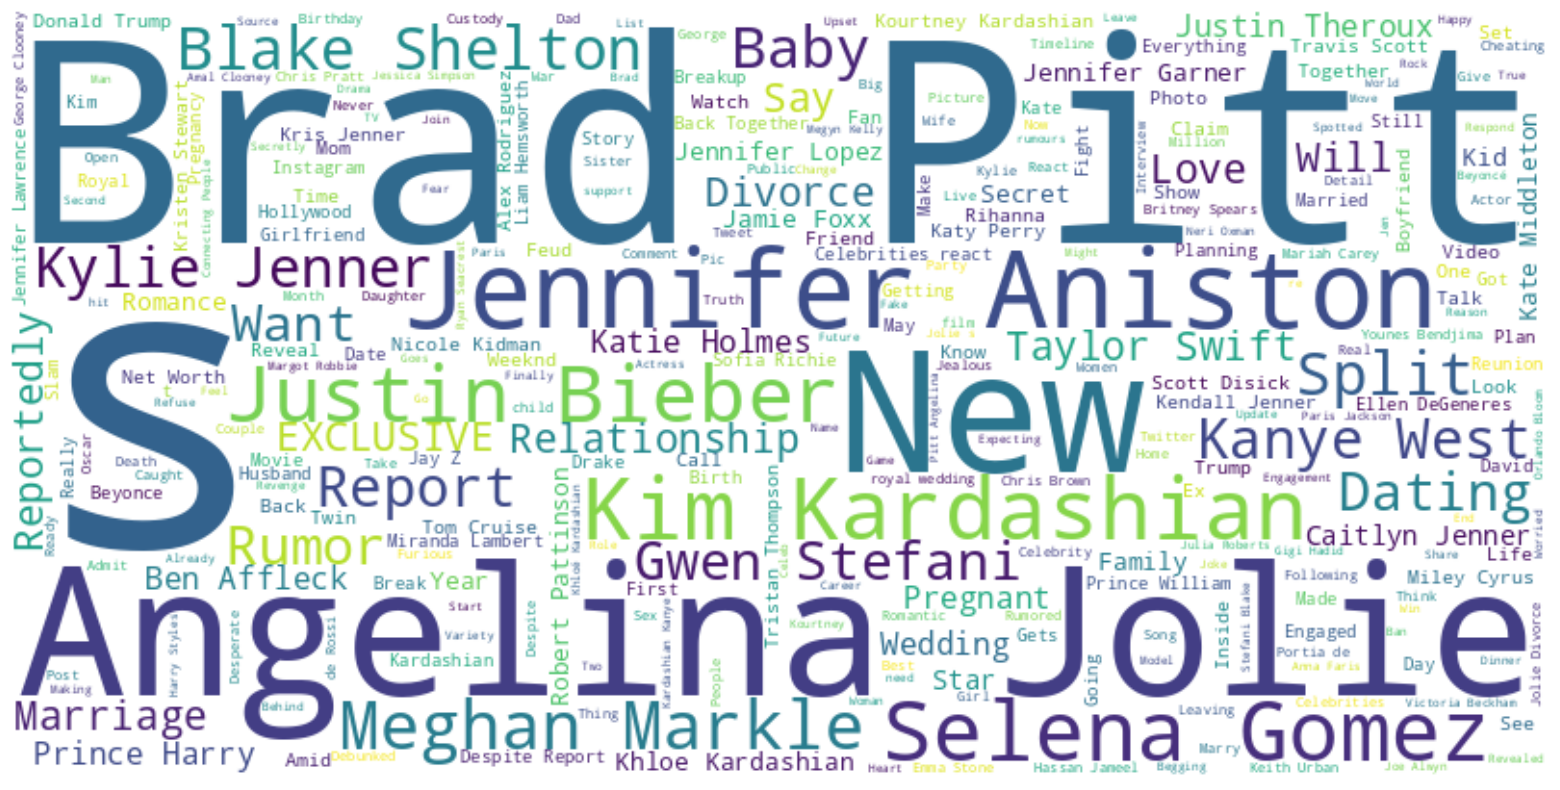

In [61]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in real_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Machine Learning

### RNN

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [62]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [63]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [64]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [65]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

We are going to use early stop, which stops when the validation loss no longer improve.

In [67]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
236/236 [==============================] - 33s 100ms/step - loss: 0.6877 - accuracy: 0.5014 - val_loss: 0.6679 - val_accuracy: 0.4847
Epoch 2/10
236/236 [==============================] - 11s 47ms/step - loss: 0.5293 - accuracy: 0.7361 - val_loss: 0.4904 - val_accuracy: 0.7615
Epoch 3/10
236/236 [==============================] - 10s 44ms/step - loss: 0.3826 - accuracy: 0.8559 - val_loss: 0.4874 - val_accuracy: 0.7934
Epoch 4/10
236/236 [==============================] - 8s 35ms/step - loss: 0.3015 - accuracy: 0.8995 - val_loss: 0.4864 - val_accuracy: 0.7883
Epoch 5/10
236/236 [==============================] - 10s 41ms/step - loss: 0.2618 - accuracy: 0.9189 - val_loss: 0.4899 - val_accuracy: 0.7908
Epoch 6/10
236/236 [==============================] - 8s 34ms/step - loss: 0.2081 - accuracy: 0.9386 - val_loss: 0.5093 - val_accuracy: 0.7895


Visualize our training over time

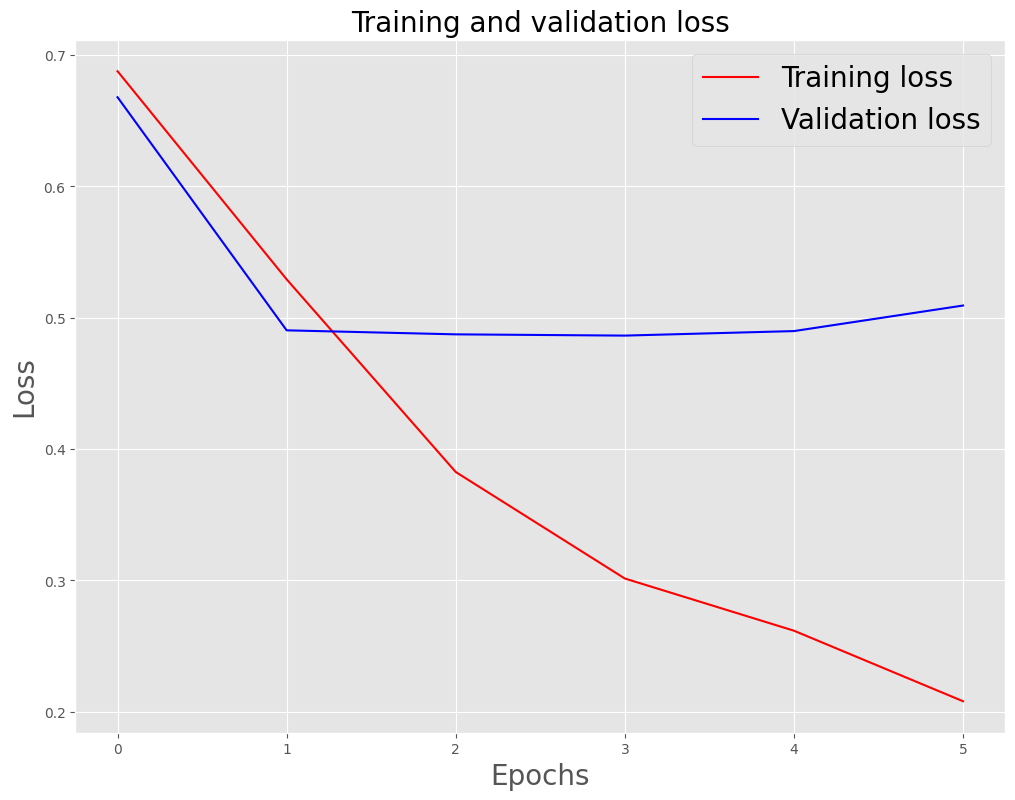

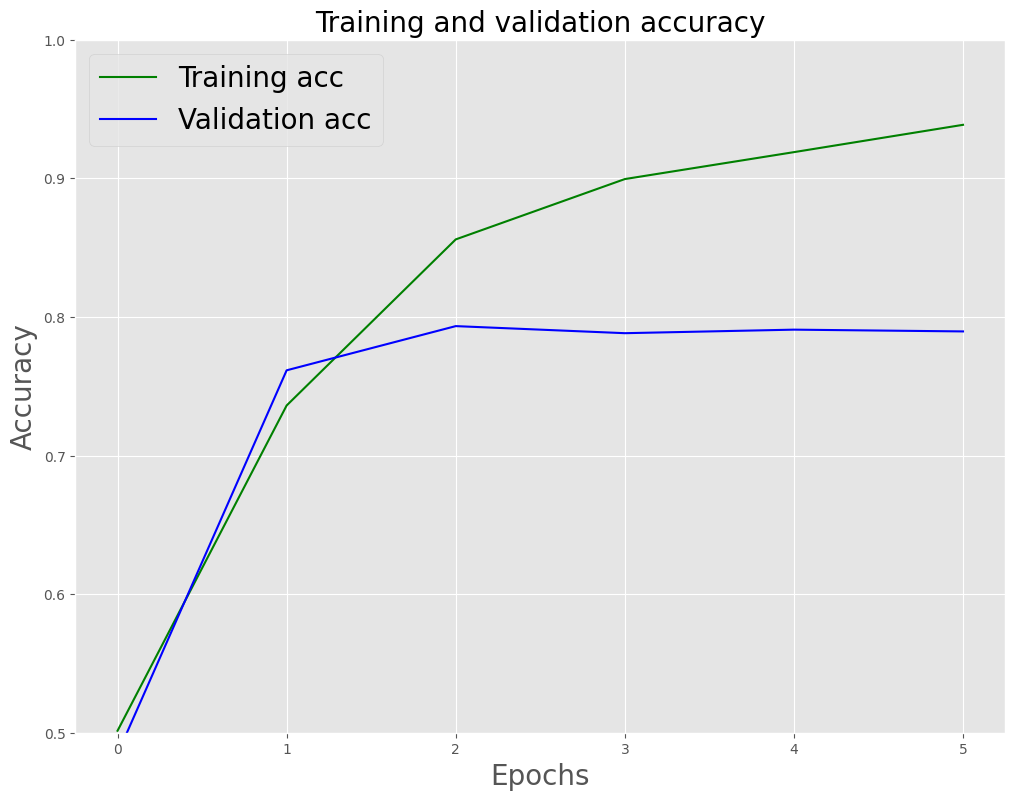

In [68]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [69]:
model.evaluate(X_test, y_test)

62/62 [==============================] - 1s 19ms/step - loss: 0.4967 - accuracy: 0.7964


[0.4967110753059387, 0.7964285612106323]

In [70]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

62/62 [==============================] - 3s 18ms/step


In [71]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.7964285714285714
Precision on testing set: 0.7576687116564417
Recall on testing set: 0.8205980066445183
F1 score on testing set: 0.7878787878787878


Confusion matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

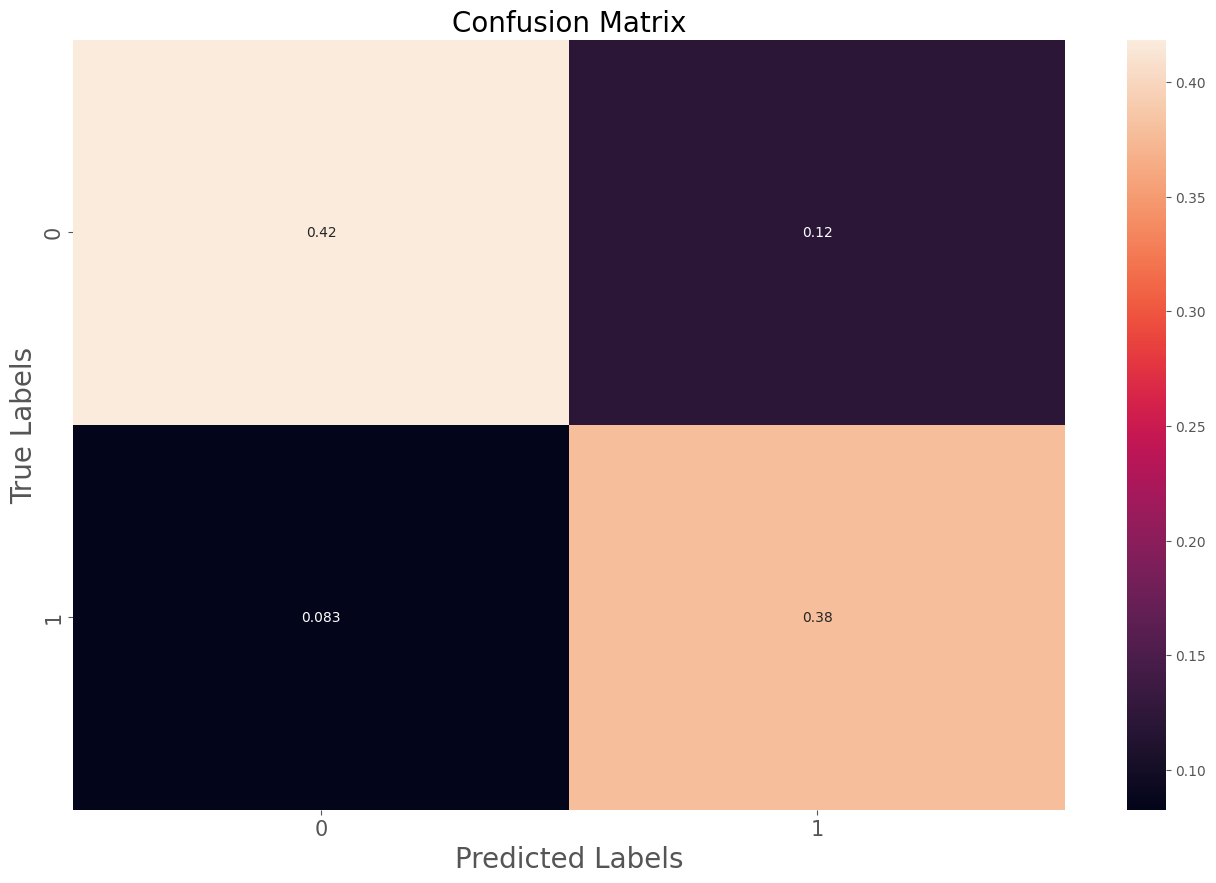

In [72]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### LSTM

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify = targets, random_state = 10)

In [74]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 12329


In [75]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [76]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 128)          1578112   
                                                                 
 bidirectional_6 (Bidirecti  (None, 512, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

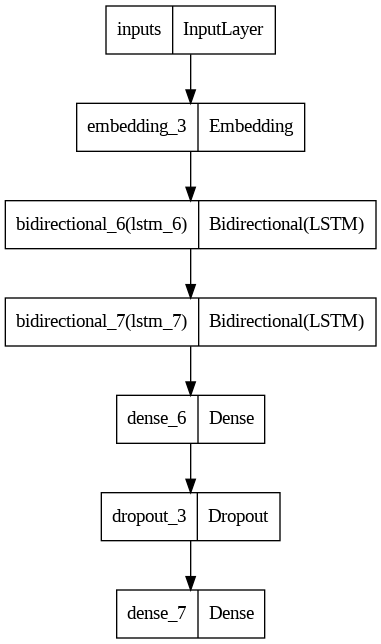

In [77]:
#plot the model architecture
tf.keras.utils.plot_model(model)

In [78]:
history = model.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
92/92 [==============================] - 31s 250ms/step - loss: 0.6927 - accuracy: 0.5127 - val_loss: 0.6912 - val_accuracy: 0.5578
Epoch 2/10
92/92 [==============================] - 13s 139ms/step - loss: 0.6769 - accuracy: 0.6163 - val_loss: 0.6399 - val_accuracy: 0.6197
Epoch 3/10
92/92 [==============================] - 12s 127ms/step - loss: 0.4844 - accuracy: 0.7888 - val_loss: 0.5113 - val_accuracy: 0.7537
Epoch 4/10
92/92 [==============================] - 11s 120ms/step - loss: 0.3287 - accuracy: 0.8756 - val_loss: 0.4806 - val_accuracy: 0.8041
Epoch 5/10
92/92 [==============================] - 10s 106ms/step - loss: 0.2394 - accuracy: 0.9217 - val_loss: 0.5032 - val_accuracy: 0.7959
Epoch 6/10
92/92 [==============================] - 9s 100ms/step - loss: 0.1748 - accuracy: 0.9466 - val_loss: 0.5431 - val_accuracy: 0.7864
Epoch 7/10
92/92 [==============================] - 9s 97ms/step - loss: 0.1272 - accuracy: 0.9636 - val_loss: 0.7055 - val_accuracy: 0.7769


In [79]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

77/77 [==============================] - 4s 26ms/step
Test Loss: 0.5162493586540222
Test Accuracy: 0.7888934016227722


In [80]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1224
           1       0.82      0.74      0.78      1225

    accuracy                           0.79      2449
   macro avg       0.79      0.79      0.79      2449
weighted avg       0.79      0.79      0.79      2449



Text(70.72222222222221, 0.5, 'Real Labels')

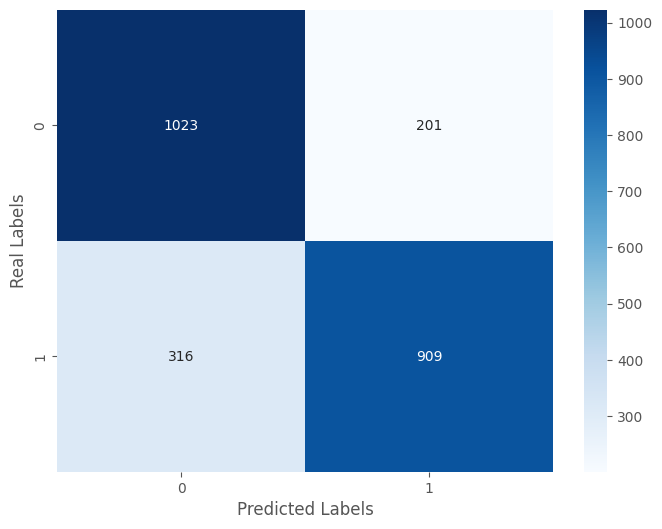

In [81]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## Logistic Regression

In [82]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [83]:
lr = LogisticRegression()
lr.fit(xv_train,y_train)

LogisticRegression()

In [84]:
pred_lr=lr.predict(xv_test)

In [85]:
lr.score(xv_test, y_test)

0.7958350347080441

In [86]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1224
           1       0.82      0.76      0.79      1225

    accuracy                           0.80      2449
   macro avg       0.80      0.80      0.80      2449
weighted avg       0.80      0.80      0.80      2449



## Random Forest Classifier

In [87]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [88]:
rfc.score(xv_test, y_test)

0.7807268272764394

In [89]:
pred_rfc = rfc.predict(xv_test)

In [90]:
pred_rfc = rfc.predict(xv_test)
rfc.score(xv_test, y_test)

0.7807268272764394

In [91]:
rfc.score(xv_test, y_test)

0.7807268272764394

In [92]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1224
           1       0.80      0.76      0.78      1225

    accuracy                           0.78      2449
   macro avg       0.78      0.78      0.78      2449
weighted avg       0.78      0.78      0.78      2449

